<a href="https://colab.research.google.com/github/Sunnnyyy16/Dacon_study/blob/main/wine_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 로드

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#경고 메시지 숨기기
import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
!cp /gdrive/MyDrive/Dacon_study/Wine/sample_submission.csv ./
!cp /gdrive/MyDrive/Dacon_study/Wine/test.csv ./
!cp /gdrive/MyDrive/Dacon_study/Wine/train.csv ./

In [ ]:
test=pd.read_csv('test.csv')
train=pd.read_csv('train.csv')

## null값 확인

In [ ]:
train.isnull().sum()

index                   0
quality                 0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
type                    0
dtype: int64

In [ ]:
test.isnull().sum()

index                   0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
type                    0
dtype: int64

# 데이터 살펴보기

6    2416
5    1788
7     924
4     186
8     152
3      26
9       5
Name: quality, dtype: int64


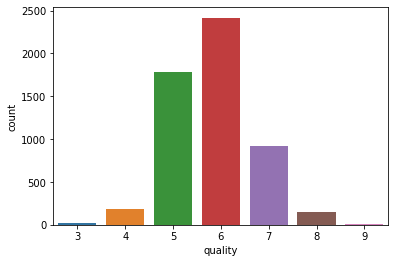

In [ ]:
print(train['quality'].value_counts())
plt.figure()
sns.countplot(x=train['quality'])
plt.show()

6이 제일 많다.

## 상관계수

In [ ]:
train_corr=train.drop(['index'], axis=1)
train_corr.corr()

,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
quality,1.000000,-0.076506,-0.261557,0.079157,-0.032848,-0.198148,0.055574,-0.039732,-0.299831,0.017931,0.042068,0.439615
fixed acidity,-0.076506,1.000000,0.210180,0.326992,-0.112544,0.303307,-0.277079,-0.323845,0.452161,-0.250462,0.300979,-0.096274
volatile acidity,-0.261557,0.210180,1.000000,-0.377986,-0.192677,0.385431,-0.352572,-0.418535,0.266759,0.264130,0.225174,-0.032897
citric acid,0.079157,0.326992,-0.377986,1.000000,0.135160,0.029121,0.129496,0.190955,0.088400,-0.322100,0.049013,-0.005376
residual sugar,-0.032848,-0.112544,-0.192677,0.135160,1.000000,-0.130339,0.396018,0.494788,0.557183,-0.259673,-0.182275,-0.361457
chlorides,-0.198148,0.303307,0.385431,0.029121,-0.130339,1.000000,-0.193143,-0.281654,0.364200,0.046937,0.400354,-0.259774
free sulfur dioxide,0.055574,-0.277079,-0.352572,0.129496,0.396018,-0.193143,1.000000,0.716829,0.027270,-0.145586,-0.189390,-0.182321
total sulfur dioxide,-0.039732,-0.323845,-0.418535,0.190955,0.494788,-0.281654,0.716829,1.000000,0.039707,-0.234412,-0.272236,-0.271566
density,-0.299831,0.452161,0.266759,0.088400,0.557183,0.364200,0.027270,0.039707,1.000000,0.020047,0.261879,-0.688053
pH,0.017931,-0.250462,0.264130,-0.322100,-0.259673,0.046937,-0.145586,-0.234412,0.020047,1.000000,0.187392,0.114959


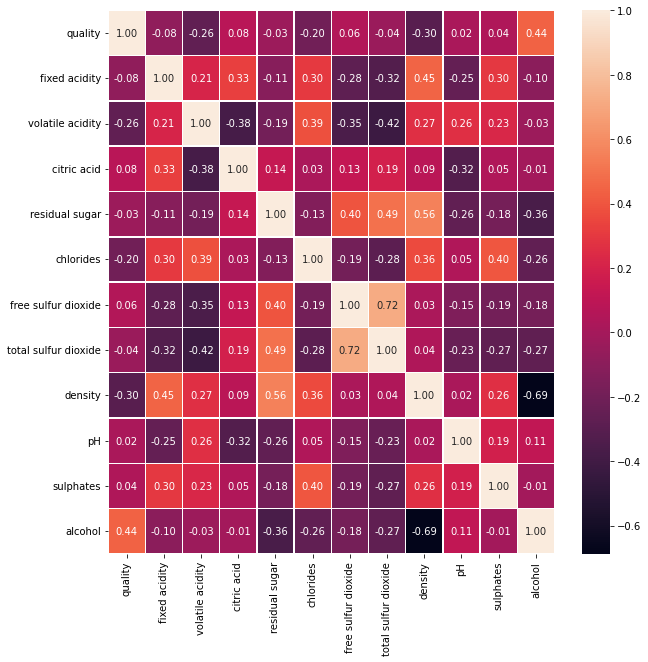

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(data = train_corr.corr(), annot=True, fmt = '.2f', linewidths=.5)

# 데이터 전처리

In [ ]:
#Library
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import plot_roc_curve,accuracy_score, confusion_matrix, plot_confusion_matrix

## 라벨인코딩

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(train['type'])
train['type'] = encoder.transform(train['type'])
test['type'] = encoder.transform(test['type'])

## 스케일 조정

In [ ]:
X = train.drop(['quality'],axis=1)
y = train['quality']

In [ ]:
#Standardscaler
scaler= StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_df= pd.DataFrame(data=X_scaled, columns=X.columns)

## train, val 데이터 split

In [ ]:
train_x, val_x, train_y, val_y = train_test_split(X_df,y,test_size=.2, random_state=42)

In [ ]:
print(np.shape(train_x))
print(np.shape(train_y))

(4397, 13)
(4397,)


In [ ]:
print(train_y[:10])

2845    6
957     6
2569    6
4449    7
5449    6
1379    5
5360    5
4043    7
2589    6
1514    6
Name: quality, dtype: int64


# 모델링

In [ ]:
# 모델링 관련 라이브러리
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
import xgboost as xgb

In [ ]:
def Model(model):
    model.fit(train_x,train_y)
    score = model.score(val_x,val_y)
    model_train_score= model.score(train_x,train_y)
    model_test_score=model.score(val_x,val_y)
    prediction = model.predict(val_x)
    cm = confusion_matrix(val_y, prediction)
    print("Testing Score\n", score)
    plot_confusion_matrix(model,val_x,val_y,cmap='OrRd')

4397 1100
Testing Score
 0.5854545454545454


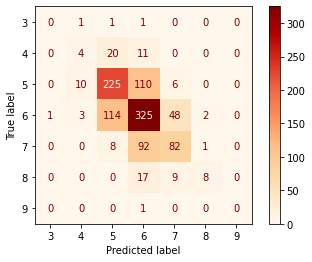

In [ ]:
xgb_clf = xgb.XGBClassifier(n_estimators=500, random_state=42)

print(len(train_x), len(val_x))
xgb_clf.fit(train_x, train_y)
Model(xgb_clf)

precision score: 0.585

--> 정확도가 안 좋아서 데이터 전처리가 더 필요할 거 같음 

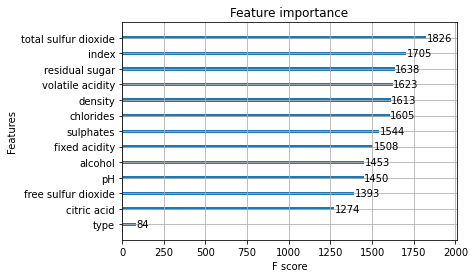

In [ ]:
xgb.plot_importance(xgb_clf)

feature importance를 보면 wine type은 등급 분류에 크게 작용하지 않음. 

## 하이퍼 파라미터 튜닝

In [ ]:
params = {'max_depth':[5,7], 'min_child_weight':[1,3], 'colsample_bytree':[0.5, 0.75]}
gridcv = GridSearchCV(xgb_clf, param_grid=params, cv=3)
gridcv.fit(train_x, train_y, early_stopping_rounds=30, eval_metric="auc",eval_set=[(train_x, train_y), (val_x, val_y)])

print(gridcv.best_params_)

XGBoostError: ignored